# Vacas Saturno Saturninas 🐮🪐
---

El siguiente Collab tiene la función de crear un nuevo dataset con los datos que se nos fue entregando; con el fin de estar trabajando en camino al reto final del socioformador "CAETEC"

Este dataset solo representa a la vaca 1213

Información de contacto
A01711063@tec.mx | 24/10/2025

---
## Proceso EDA del csv - Datos de Ordeña
---

## Funciones Pipeline



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class MilkingDataPipeline:
    """
    Pipeline para procesar datos de ordeño y prepararlos para análisis
    """

    def __init__(self):
        self.columns_to_drop = [
            'Usuario',
            'RCS (* 1000 células / ml)',
            'Razón de la desviación',
            'Ubre',
            'Pezón',
            'Patada',
            'Incompleto',
            'Pezones no encontrados'
        ]

        self.rename_mapping = {
            'DI': 'DI - media de flujos (kg/min)',
            'DD': 'DD - media de flujos (kg/min)',
            'TI': 'TI - media de flujos (kg/min)',
            'TD': 'TD - media de flujos (kg/min)',

            'DI.1': 'DI - sangre (ppm)',
            'DD.1': 'DD - sangre (ppm)',
            'TI.1': 'TI - sangre (ppm)',
            'TD.1': 'TD - sangre (ppm)',

            'DI.2': 'DI - conductividad (ms/cm)',
            'DD.2': 'DD - conductividad (ms/cm)',
            'TI.2': 'TI - conductividad (ms/cm)',
            'TD.2': 'TD - conductividad (ms/cm)',

            'DI.3': 'DI - flujos (kg/min)',
            'DD.3': 'DD - flujos (kg/min)',
            'TI.3': 'TI - flujos (kg/min)',
            'TD.3': 'TD - flujos (kg/min)',

            'DI.4': 'DI - producciones (kg)',
            'DD.4': 'DD - producciones (kg)',
            'TI.4': 'TI - producciones (kg)',
            'TD.4': 'TD - producciones (kg)',
        }

    def step1_parse_datetime(self, df):
        """Paso 1: Separar fecha y hora de 'Hora de inicio'"""
        print("=" * 60)
        print("PASO 1: Procesando fechas y horas")
        print("=" * 60)

        # Parsear la columna de fecha/hora
        # Formato: "06/09/2024 04:42 a. m."
        df['Hora de inicio'] = df['Hora de inicio'].str.replace(' a. m.', ' AM')
        df['Hora de inicio'] = df['Hora de inicio'].str.replace(' p. m.', ' PM')

        df['datetime'] = pd.to_datetime(df['Hora de inicio'], format='%d/%m/%Y %I:%M %p', errors='coerce')

        # Eliminar la columna original y mantener datetime
        df = df.drop(columns=['Hora de inicio'])

        print(f"✓ Datetime parseado correctamente")

        return df

    def step2_drop_columns(self, df):
        """Paso 2: Eliminar columnas no necesarias"""
        print("\n" + "=" * 60)
        print("PASO 2: Eliminando columnas")
        print("=" * 60)

        # Verificar qué columnas existen antes de eliminar
        existing_cols_to_drop = [col for col in self.columns_to_drop if col in df.columns]
        missing_cols = [col for col in self.columns_to_drop if col not in df.columns]

        if missing_cols:
            print(f"⚠️  Columnas no encontradas (se omitirán): {missing_cols}")

        df_dropped = df.drop(columns=existing_cols_to_drop, errors='ignore')
        print(f"✓ Columnas eliminadas: {len(existing_cols_to_drop)}")
        print(f"✓ Columnas restantes: {len(df_dropped.columns)}")

        return df_dropped

    def step3_rename_columns(self, df):
        """Paso 3: Renombrar columnas"""
        print("\n" + "=" * 60)
        print("PASO 2: Renombrando columnas")
        print("=" * 60)

        df_renamed = df.rename(columns=self.rename_mapping)
        print(f"✓ Columnas renombradas: {len(self.rename_mapping)}")

        return df_renamed

    def step4_remove_duplicates(self, df):
        """Paso 4: Eliminar duplicados"""
        print("\n" + "=" * 60)
        print("PASO 4: Eliminando duplicados")
        print("=" * 60)

        duplicates_before = df.duplicated().sum()
        print(f"Duplicados antes de eliminar: {duplicates_before}")

        df_cleaned = df.drop_duplicates()

        duplicates_after = df_cleaned.duplicated().sum()
        print(f"Duplicados después de eliminar: {duplicates_after}")
        print(f"✓ Registros eliminados: {len(df) - len(df_cleaned)}")
        print(f"✓ Registros finales: {len(df_cleaned)}")

        return df_cleaned

    def step5_log_transform(self, df):
        """Paso 5: Aplicar transformación logarítmica a variables apropiadas"""
        print("\n" + "=" * 60)
        print("PASO 5: Aplicando transformación logarítmica")
        print("=" * 60)

        # Variables que definitivamente deben transformarse
        production_vars = [
            'Producción (kg)',
            'DI - producciones (kg)',
            'DD - producciones (kg)',
            'TI - producciones (kg)',
            'TD - producciones (kg)'
        ]

        blood_vars = [
            'DI - sangre (ppm)',
            'DD - sangre (ppm)',
            'TI - sangre (ppm)',
            'TD - sangre (ppm)'
        ]

        # Variables opcionales (solo si tienen alta variabilidad)
        flow_vars = [
            'DI - flujos (kg/min)',
            'DD - flujos (kg/min)',
            'TI - flujos (kg/min)',
            'TD - flujos (kg/min)',
            'DI - media de flujos (kg/min)',
            'DD - media de flujos (kg/min)',
            'TI - media de flujos (kg/min)',
            'TD - media de flujos (kg/min)'
        ]

        # Aplicar transformación logarítmica
        transformed_count = 0

        # Producción (crítico)
        for var in production_vars:
            if var in df.columns:
                log_name = f"log_{var.split(' - ')[0]}_prod" if ' - ' in var else 'log_produccion'
                df[log_name] = np.log1p(df[var])  # log1p para manejar valores cercanos a 0
                transformed_count += 1
                print(f"✓ {var} → {log_name}")

        # Sangre (recomendado)
        for var in blood_vars:
            if var in df.columns:
                log_name = f"log_{var.split(' - ')[0]}_sangre"
                df[log_name] = np.log1p(df[var])
                transformed_count += 1
                print(f"✓ {var} → {log_name}")

        # Flujos (opcional - verificar primero si tienen alta variabilidad)
        print(f"\n⚠️  Variables de flujo NO transformadas (baja variabilidad esperada)")
        print(f"   Si necesitas transformarlas, usa: np.log1p(df[columna])")

        print(f"\n✓ Total de variables transformadas: {transformed_count}")
        print(f"✓ Nota: Se usa log1p (log(1+x)) para manejar valores cercanos a 0")

        return df

    def step6_drop_null_values(self, df):
        """Paso 6: Eliminar filas con valores nulos"""
        print("\n" + "=" * 60)
        print("PASO 6: Eliminando filas con valores nulos")
        print("=" * 60)

        # Contar valores nulos antes
        total_nulls_before = df.isnull().sum().sum()
        rows_before = len(df)

        print(f"🔍 Valores nulos totales antes de limpiar: {total_nulls_before}")

        # Eliminar filas con cualquier valor nulo
        df_cleaned = df.dropna()

        # Contar después
        total_nulls_after = df_cleaned.isnull().sum().sum()
        rows_after = len(df_cleaned)

        print(f"🧹 Filas eliminadas: {rows_before - rows_after}")
        print(f"📉 Registros finales: {rows_after}")
        print(f"✅ Valores nulos restantes: {total_nulls_after}")

        return df_cleaned

    def run_pipeline(self, df):
        """
        Ejecutar el pipeline completo

        Parameters:
        -----------
        df : DataFrame
            DataFrame original

        Returns:
        --------
        DataFrame : DataFrame procesado y limpio
        """
        print("\n" + "🚀 " * 20)
        print("INICIANDO PIPELINE DE PROCESAMIENTO DE DATOS")
        print("🚀 " * 20)

        # Ejecutar pasos secuencialmente
        df = self.step1_parse_datetime(df.copy())
        df = self.step2_drop_columns(df)
        df = self.step3_rename_columns(df)
        df = self.step4_remove_duplicates(df)
        df = self.step5_log_transform(df)
        df = self.step6_drop_null_values(df)

        print("\n" + "✅ " * 20)
        print("PIPELINE COMPLETADO EXITOSAMENTE")
        print("✅ " * 20)
        print(f"\n📊 DataFrame final:")
        print(f"   Shape: {df.shape}")
        print(f"   Columnas: {len(df.columns)}")
        print(f"   Registros: {len(df)}")

        return df


In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Montar Drive (solo necesario en Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Buscar todos los archivos CSV dentro de la carpeta
ruta_carpeta = '/content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/'
archivos = glob.glob(ruta_carpeta + '*.csv')

# Mostrar los archivos encontrados (opcional, para verificar)
print(f'Se encontraron {len(archivos)} archivos CSV:')
for f in archivos:
    print(f' - {f}')

# Leer y concatenar todos los archivos
df_completo = pd.concat([pd.read_csv(f, header=1) for f in archivos], ignore_index=True)

# Mostrar primeras filas y dimensiones
display(df_completo.head())
print("Forma final del dataframe:", df_completo.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Se encontraron 44 archivos CSV:
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1236.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1226.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1590.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1514.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1511.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1575.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1510.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a EO-PO 1216.csv
 - /content/drive/MyDrive/IA_Avanzada/Vacas/Datos de ordeña/Todas las visitas a

,Hora de inicio,Acción,Duración (mm:ss),Producción (kg),Número de ordeño,RCS (* 1000 células / ml),Patada,Incompleto,Pezones no encontrados,Ubre,...,Destino Leche,Razón de la desviación,DI.3,DD.3,TI.3,TD.3,DI.4,DD.4,TI.4,TD.4
0,03/09/2024 02:13 p. m.,Ordeño,15:01,12.23,2.0,NaN,NaN,NaN,NaN,1.0,...,Tanque,NaN,1.38,1.26,1.14,1.08,3.55,2.40,2.50,3.78
1,15/09/2024 12:12 a. m.,Ordeño,08:43,9.22,1.0,NaN,NaN,NaN,NaN,1.0,...,Tanque,NaN,1.14,1.20,1.20,0.96,2.31,2.24,2.62,2.05
2,15/09/2024 09:48 p. m.,Ordeño,13:10,6.03,4.0,NaN,NaN,DD,NaN,1.0,...,Tanque,NaN,1.14,0.78,1.14,0.90,1.37,0.56,2.05,2.05
3,16/09/2024 01:45 p. m.,Ordeño,12:00,9.23,2.0,NaN,NaN,NaN,NaN,1.0,...,Tanque,NaN,1.74,1.20,1.20,0.72,1.85,4.02,2.54,0.82
4,17/09/2024 02:54 p. m.,Ordeño,10:29,9.91,2.0,NaN,NaN,NaN,NaN,1.0,...,Tanque,NaN,1.02,1.08,1.02,0.84,1.84,3.76,2.74,1.57


Forma final del dataframe: (49602, 35)


#### Información del dataset inicial

In [ ]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49602 entries, 0 to 49601
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Hora de inicio             49602 non-null  object 
 1   Acción                     49602 non-null  object 
 2   Duración (mm:ss)           49602 non-null  object 
 3   Producción (kg)            48437 non-null  float64
 4   Número de ordeño           48437 non-null  float64
 5   RCS (* 1000 células / ml)  0 non-null      float64
 6   Patada                     7362 non-null   object 
 7   Incompleto                 5787 non-null   object 
 8   Pezones no encontrados     6130 non-null   object 
 9   Ubre                       48437 non-null  float64
 10  Pezón                      5394 non-null   object 
 11  DI                         48014 non-null  float64
 12  DD                         46868 non-null  float64
 13  TI                         45614 non-null  flo

#### Utilizando el Pipeline de limpieza
---
Sigiendo nuestro [reporte de calidad](https://www.notion.so/Data-quality-report-287aa3a48b0d80cdbcb6f352fe683542?source=copy_link) las columnas que si o si vamos a dropear por que no añaden valor son:

In [ ]:
# Inicializar y ejecutar pipeline
pipeline = MilkingDataPipeline()
df_cleaned = pipeline.run_pipeline(df_completo)

# Ver el resultado
print("\n" + "=" * 60)
print("RESULTADO FINAL")
print("=" * 60)
print(df_cleaned.info())


🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
INICIANDO PIPELINE DE PROCESAMIENTO DE DATOS
🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
PASO 1: Procesando fechas y horas
✓ Datetime parseado correctamente

PASO 2: Eliminando columnas
✓ Columnas eliminadas: 8
✓ Columnas restantes: 27

PASO 2: Renombrando columnas
✓ Columnas renombradas: 20

PASO 4: Eliminando duplicados
Duplicados antes de eliminar: 15
Duplicados después de eliminar: 0
✓ Registros eliminados: 15
✓ Registros finales: 49587

PASO 5: Aplicando transformación logarítmica
✓ Producción (kg) → log_produccion
✓ DI - producciones (kg) → log_DI_prod
✓ DD - producciones (kg) → log_DD_prod
✓ TI - producciones (kg) → log_TI_prod
✓ TD - producciones (kg) → log_TD_prod
✓ DI - sangre (ppm) → log_DI_sangre
✓ DD - sangre (ppm) → log_DD_sangre
✓ TI - sangre (ppm) → log_TI_sangre
✓ TD - sangre (ppm) → log_TD_sangre

⚠️  Variables de flujo NO transformadas (baja variabilidad esperada)
   Si necesitas transformarlas, usa: np.log1p(df[columna])

✓ Tot

In [ ]:
df_cleaned.tail(10)

,Acción,Duración (mm:ss),Producción (kg),Número de ordeño,DI - media de flujos (kg/min),DD - media de flujos (kg/min),TI - media de flujos (kg/min),TD - media de flujos (kg/min),DI - sangre (ppm),DD - sangre (ppm),...,datetime,log_produccion,log_DI_prod,log_DD_prod,log_TI_prod,log_TD_prod,log_DI_sangre,log_DD_sangre,log_TI_sangre,log_TD_sangre
49565,Ordeño,04:03,10.78,1.0,1.56,1.80,1.68,1.56,0.0,0.0,...,2025-10-16 02:41:00,2.466403,1.211941,1.321756,1.383791,1.302913,0.0,0.0,0.0,0.0
49566,Ordeño,04:09,11.70,2.0,1.50,1.80,1.68,1.62,0.0,0.0,...,2025-10-16 12:17:00,2.541602,1.238374,1.432701,1.401183,1.386294,0.0,0.0,0.0,0.0
49567,Ordeño,03:54,9.27,3.0,1.50,1.62,1.74,1.50,0.0,0.0,...,2025-10-16 19:55:00,2.329227,1.091923,1.232560,1.269761,1.193922,0.0,0.0,0.0,0.0
49568,Ordeño,05:12,15.72,1.0,1.68,1.98,1.86,1.62,0.0,0.0,...,2025-10-17 09:52:00,2.816606,1.560248,1.658228,1.613430,1.545433,0.0,0.0,0.0,0.0
49569,Ordeño,04:29,11.85,2.0,1.62,1.74,1.68,1.62,0.0,0.0,...,2025-10-17 19:41:00,2.553344,1.283708,1.388791,1.439835,1.388791,0.0,0.0,0.0,0.0
49570,Ordeño,05:45,13.09,1.0,1.56,1.92,1.74,1.74,0.0,0.0,...,2025-10-18 07:19:00,2.645465,1.348073,1.508512,1.470176,1.474763,0.0,0.0,0.0,0.0
49571,Ordeño,04:46,9.24,2.0,1.50,1.68,1.74,1.62,0.0,0.0,...,2025-10-18 15:36:00,2.326302,1.111858,1.235471,1.223775,1.211941,0.0,0.0,0.0,0.0
49572,Ordeño,07:19,14.88,1.0,1.44,1.86,1.74,1.74,0.0,0.0,...,2025-10-19 04:50:00,2.765060,1.506297,1.642873,1.536867,1.515127,0.0,0.0,0.0,0.0
49573,Ordeño,04:36,13.60,2.0,1.62,1.98,1.74,1.74,0.0,0.0,...,2025-10-19 15:41:00,2.681022,1.439835,1.474763,1.515127,1.495149,0.0,0.0,0.0,0.0
49574,Ordeño,05:05,15.51,1.0,1.56,1.98,1.74,1.74,0.0,0.0,...,2025-10-20 05:44:00,2.803966,1.576915,1.562346,1.585145,1.613430,0.0,0.0,0.0,0.0


In [ ]:
df_cleaned.shape

(41608, 36)

### Parte II EDA. Graficación
---

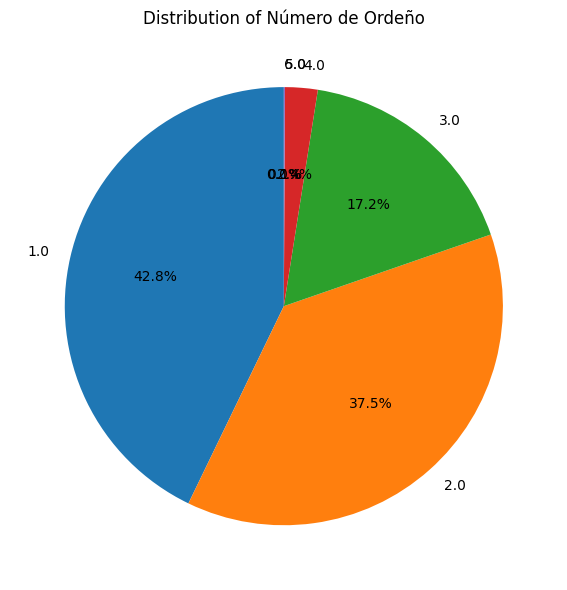

In [ ]:
# Create pie charts for 'Número de ordeño'

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Pie chart for 'Número de ordeño'
numero_ordeno_counts = df_cleaned['Número de ordeño'].value_counts(dropna=False)
ax.pie(numero_ordeno_counts, labels=numero_ordeno_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Número de Ordeño')

plt.tight_layout()
plt.show()

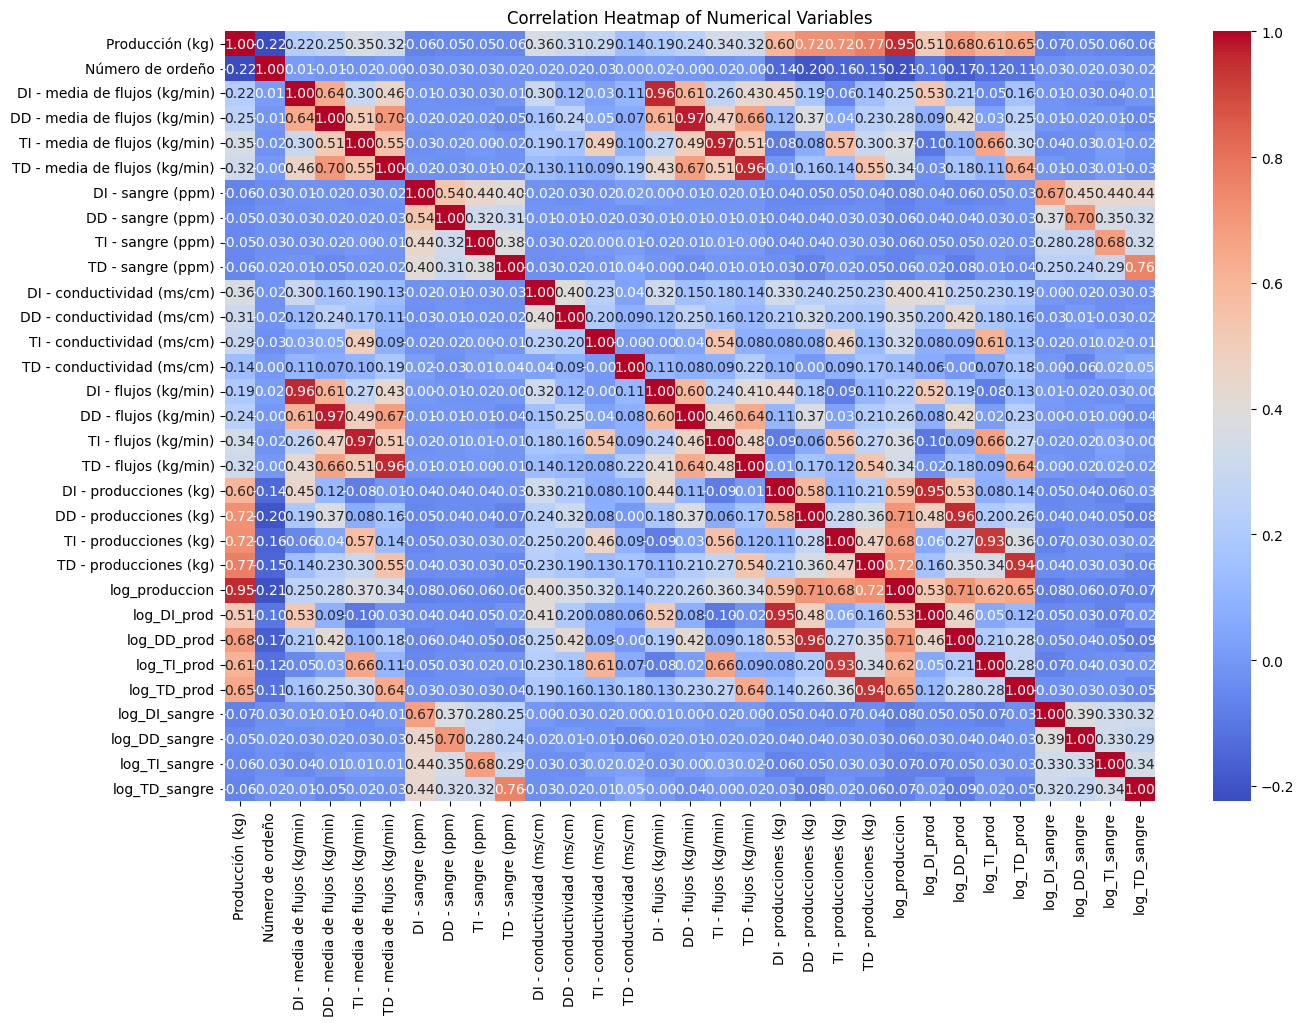

In [ ]:
# Select only numerical columns for correlation analysis, excluding boolean dummy variables
numerical_cols_for_corr = df_cleaned.select_dtypes(include=np.number).columns.tolist()
boolean_cols = df_cleaned.select_dtypes(include=bool).columns.tolist()
numerical_cols_for_corr = [col for col in numerical_cols_for_corr if col not in boolean_cols]


# Calculate the correlation matrix
correlation_matrix = df_cleaned[numerical_cols_for_corr].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

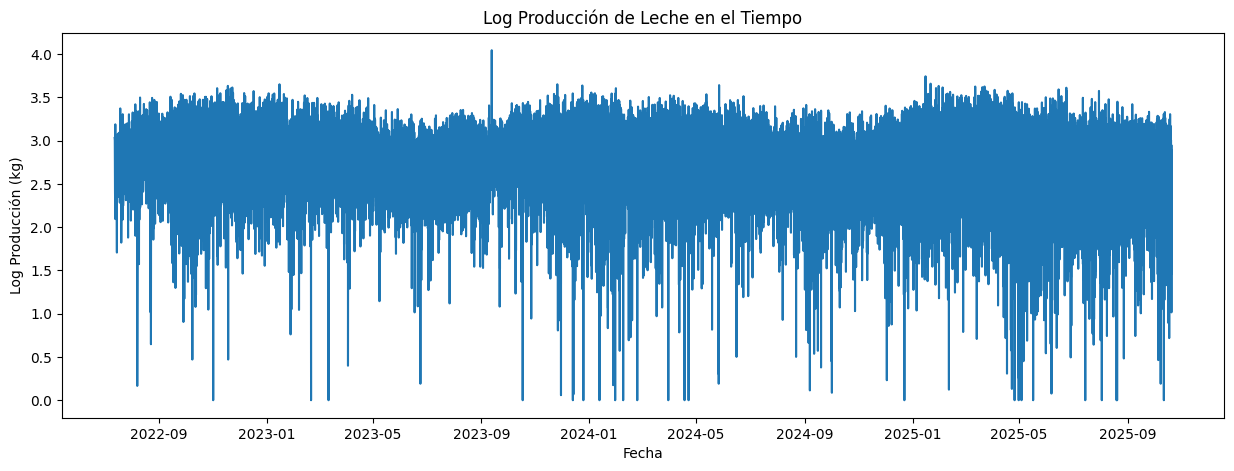

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar datetime como índice
df_ts = df_cleaned.set_index('datetime').sort_index()

# Gráfica de serie temporal
plt.figure(figsize=(15, 5))
plt.plot(df_ts['log_produccion'])
plt.title('Log Producción de Leche en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Log Producción (kg)')
plt.show()

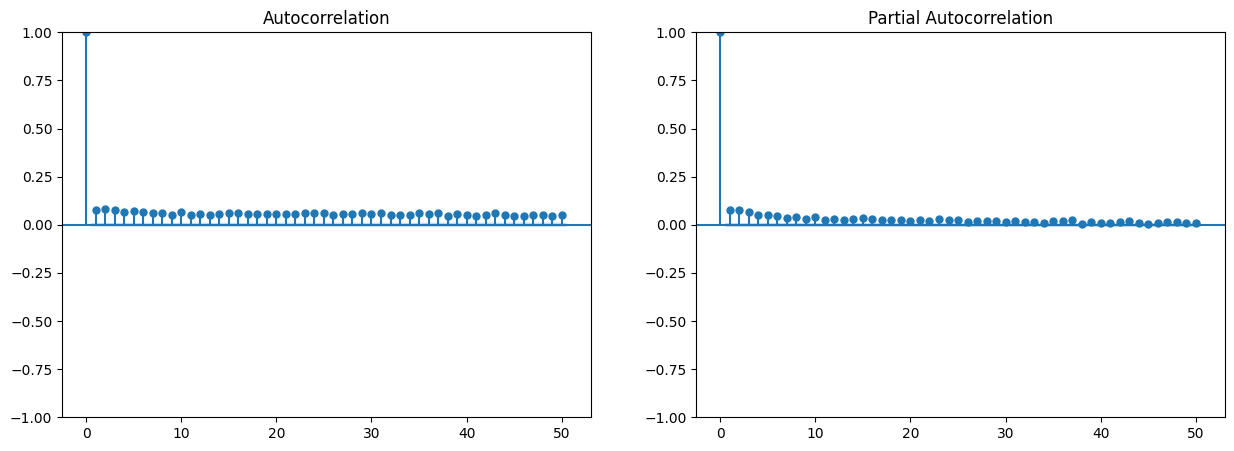

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF muestra correlaciones con lags anteriores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df_ts['log_produccion'].dropna(), lags=50, ax=axes[0])
plot_pacf(df_ts['log_produccion'].dropna(), lags=50, ax=axes[1])
plt.show()

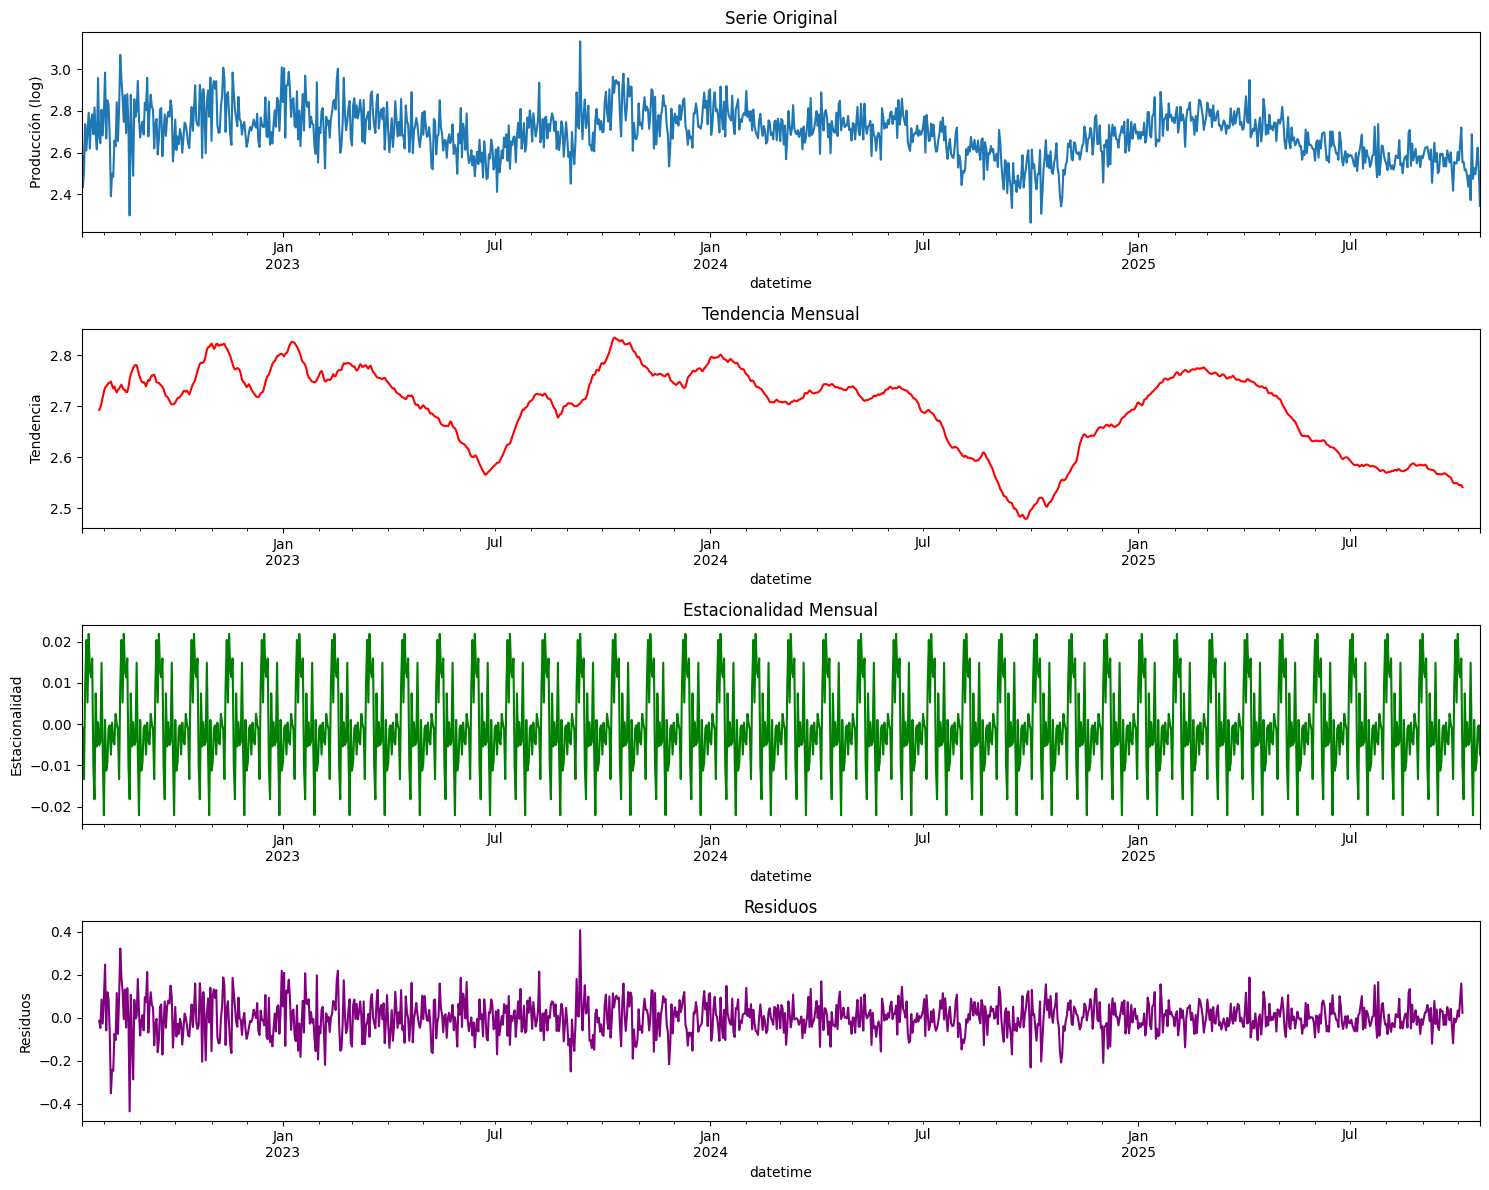

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_daily = df_ts['log_produccion'].resample('D').mean()

# Solo descomposición mensual
decomp_mensual = seasonal_decompose(df_daily.dropna(), model='additive', period=30)

# Crear figura con los 4 componentes de la descomposición mensual
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomp_mensual.observed.plot(ax=axes[0], title='Serie Original')
axes[0].set_ylabel('Producción (log)')

decomp_mensual.trend.plot(ax=axes[1], title='Tendencia Mensual', color='red')
axes[1].set_ylabel('Tendencia')

decomp_mensual.seasonal.plot(ax=axes[2], title='Estacionalidad Mensual', color='green')
axes[2].set_ylabel('Estacionalidad')

decomp_mensual.resid.plot(ax=axes[3], title='Residuos', color='purple')
axes[3].set_ylabel('Residuos')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Preparar datos MENSUALES
df_monthly = df_ts['log_produccion'].resample('M').mean().dropna()

print(f"Observaciones mensuales: {len(df_monthly)}")
print(f"Rango de fechas: {df_monthly.index[0]} a {df_monthly.index[-1]}")

# Normalizar
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_monthly.values.reshape(-1, 1))

# Crear secuencias
def create_sequences(data, lookback=6, forecast_horizon=3):
    """
    lookback: meses históricos para predecir
    forecast_horizon: meses a predecir hacia adelante
    """
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast_horizon])
    return np.array(X), np.array(y)

# Configuración
LOOKBACK = 6  # Usar últimos 6 meses
FORECAST_HORIZON = 3  # Predecir próximos 3 meses

X, y = create_sequences(data_scaled, LOOKBACK, FORECAST_HORIZON)

print(f"\nTotal de secuencias creadas: {len(X)}")

# Verificar que tenemos suficientes datos
if len(X) < 10:
    print("⚠️ ADVERTENCIA: Muy pocas secuencias para entrenar. Ajustando parámetros...")
    LOOKBACK = 3  # Reducir a 3 meses
    FORECAST_HORIZON = 1  # Predecir solo 1 mes adelante
    X, y = create_sequences(data_scaled, LOOKBACK, FORECAST_HORIZON)
    print(f"Nuevas secuencias con LOOKBACK={LOOKBACK}, HORIZON={FORECAST_HORIZON}: {len(X)}")

# Split train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nShape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Secuencias de entrenamiento: {len(X_train)}")
print(f"Secuencias de prueba: {len(X_test)}")

# Verificar que hay suficientes datos para entrenar
if len(X_train) < 5:
    print("\n⚠️ ERROR: Insuficientes datos para entrenar")
    print("Considera usar un modelo más simple como ARIMA/SARIMA")
else:
    # Modelo LSTM Multi-Step (adaptado para pocos datos)
    model = keras.Sequential([
        layers.GRU(32, activation='tanh', return_sequences=True,
                  input_shape=(LOOKBACK, 1),
                  kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.GRU(16, activation='tanh',
                  kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(24, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(FORECAST_HORIZON)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss='huber',
        metrics=['mae', 'mse', 'accuracy']
    )

    model.summary()

    # Entrenar (con menos épocas para evitar overfitting)
    history = model.fit(
        X_train, y_train,
        epochs=50,  # Reducido de 100 a 50
        batch_size=4,  # Batch size más pequeño
        validation_split=0.2,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
        ],
        verbose=1
    )

    # Evaluar
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTrain Loss: {train_loss[0]:.4f}, Train MAE: {train_loss[1]:.4f}")
    print(f"Test Loss: {test_loss[0]:.4f}, Test MAE: {test_loss[1]:.4f}")

Observaciones mensuales: 40
Rango de fechas: 2022-07-31 00:00:00 a 2025-10-31 00:00:00

Total de secuencias creadas: 32

Shape X_train: (25, 6, 1)
Shape y_train: (25, 3, 1)
Secuencias de entrenamiento: 25
Secuencias de prueba: 7


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 6, 32)          │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,435 (25.14 KB)

 Trainable params: 6,339 (24.76 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.0245 - loss: 1.1903 - mae: 1.1892 - mse: 2.3705 - val_accuracy: 0.0000e+00 - val_loss: 0.5627 - val_mae: 0.5174 - val_mse: 0.3448 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0254 - loss: 1.0249 - mae: 1.0573 - mse: 1.5905 - val_accuracy: 0.0000e+00 - val_loss: 0.5534 - val_mae: 0.5114 - val_mse: 0.3413 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0395 - loss: 1.1112 - mae: 1.1333 - mse: 2.0673 - val_accuracy: 0.0667 - val_loss: 0.5440 - val_mae: 0.5068 - val_mse: 0.3375 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0220 - loss: 0.9574 - mae: 0.9910 - mse: 1.5421 - val_accuracy: 0.1000 - val_loss: 0.5350 - val_mae: 0.5037 - val_mse: 0.3345 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0442 - loss: 0.8883 - mae: 0.8998 - mse: 1.2756 - val_accuracy: 0.1000 - val

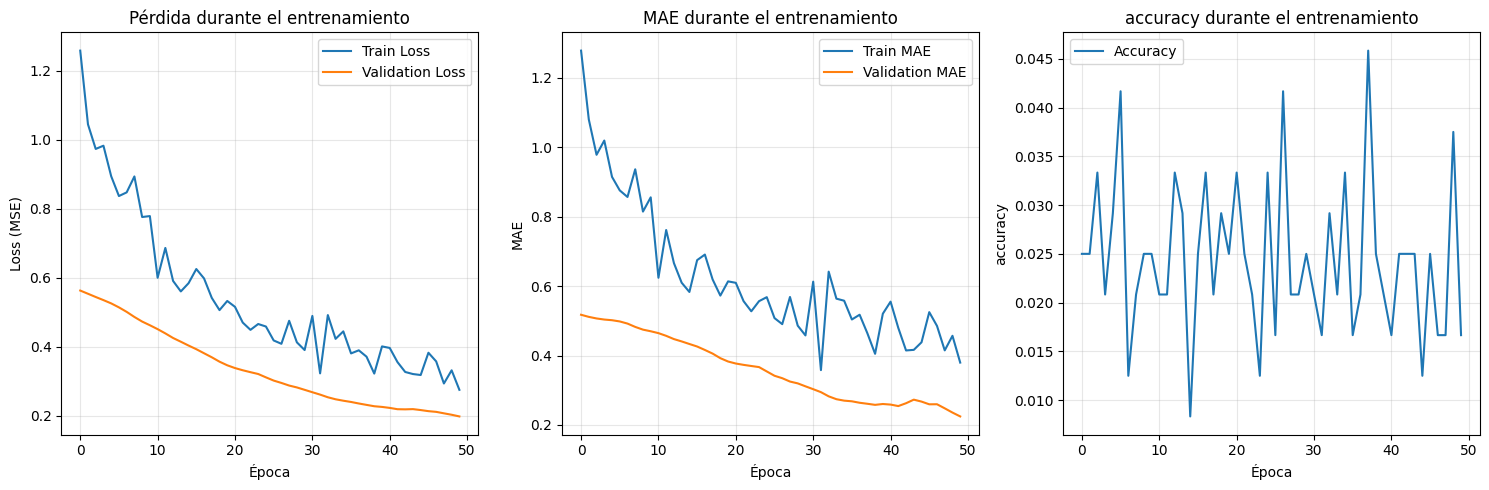

In [ ]:
# Graficar historial de entrenamiento
plt.figure(figsize=(15, 5))

# Change the layout to 1 row and 3 columns to accommodate three plots
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


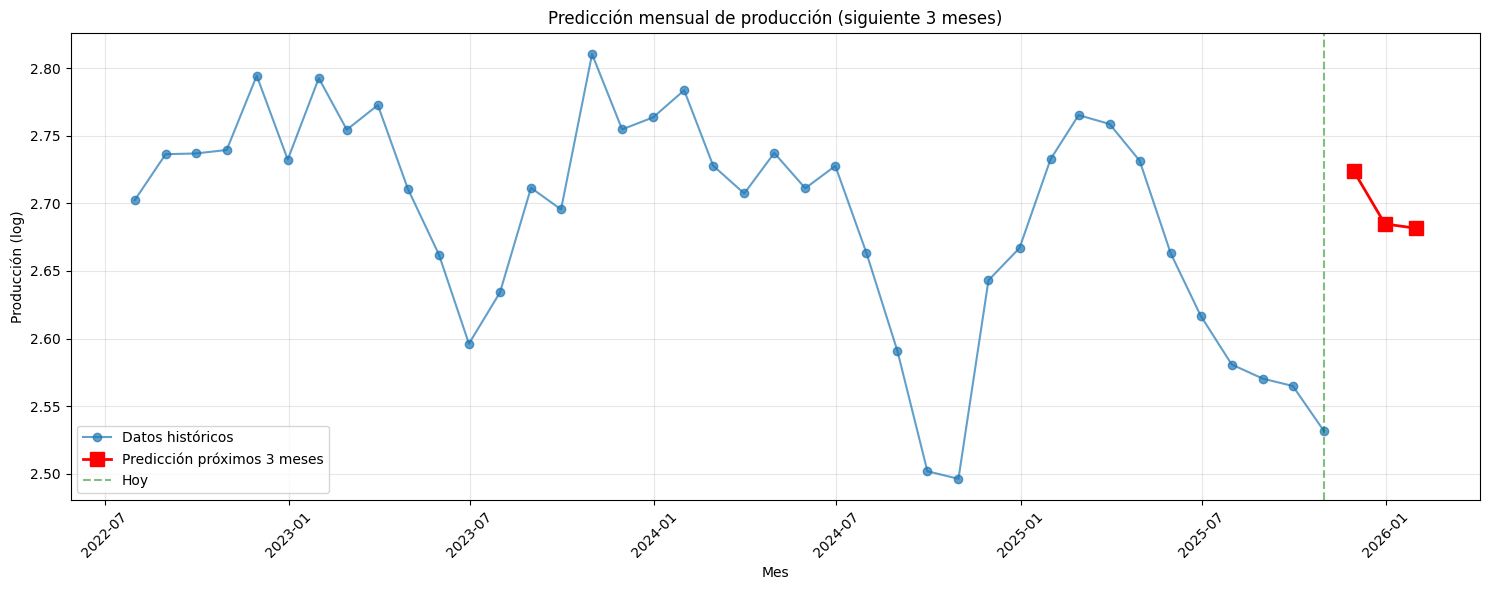


=== Predicción para los próximos 3 meses ===
2025-11: 2.7237
2025-12: 2.6848
2026-01: 2.6816


In [ ]:
# Predecir los próximos meses usando los últimos datos disponibles
ultimo_periodo = data_scaled[-LOOKBACK:].reshape(1, LOOKBACK, 1)

# Predecir
prediccion_futura = model.predict(ultimo_periodo)

# Desnormalizar
prediccion_futura_original = scaler.inverse_transform(
    prediccion_futura.reshape(-1, 1)
).flatten()

# Crear fechas futuras
ultima_fecha = df_monthly.index[-1]
fechas_futuras = pd.date_range(start=ultima_fecha + pd.DateOffset(months=1),
                               periods=FORECAST_HORIZON, freq='M')

# Visualizar
plt.figure(figsize=(15, 6))
plt.plot(df_monthly.index, df_monthly.values, 'o-', label='Datos históricos', alpha=0.7)
plt.plot(fechas_futuras, prediccion_futura_original,
         's-', label=f'Predicción próximos {FORECAST_HORIZON} meses',
         color='red', linewidth=2, markersize=10)
plt.axvline(x=ultima_fecha, color='green', linestyle='--', alpha=0.5, label='Hoy')
plt.xlabel('Mes')
plt.ylabel('Producción (log)')
plt.title(f'Predicción mensual de producción (siguiente {FORECAST_HORIZON} meses)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n=== Predicción para los próximos {FORECAST_HORIZON} meses ===")
for fecha, valor in zip(fechas_futuras, prediccion_futura_original):
    print(f"{fecha.strftime('%Y-%m')}: {valor:.4f}")